In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors, DistanceMetric
import pandas as pd
import numpy as np
%matplotlib inline

# Dummy example on short texts

## Bag of word model

In [4]:
# list of text documents
text_test = ["This is a test document","this is a second text","and here is a third text", "this is a dum text!"]

In [5]:
# create the transform
vectorizer_test = CountVectorizer()
# tokenize and build vocab
vectorizer_test.fit(text_test)
# summarize
print(vectorizer_test.vocabulary_)

{'this': 9, 'is': 4, 'test': 6, 'document': 1, 'second': 5, 'text': 7, 'and': 0, 'here': 3, 'third': 8, 'dum': 2}


In [6]:
# encode document
vector_test = vectorizer_test.transform(text_test)
# summarize encoded vector
print(vector_test.toarray())

[[0 1 0 0 1 0 1 0 0 1]
 [0 0 0 0 1 1 0 1 0 1]
 [1 0 0 1 1 0 0 1 1 0]
 [0 0 1 0 1 0 0 1 0 1]]


## TF-IDF of documents

In [7]:
# create the transform
vectorizer_tfidf_test = TfidfVectorizer()
# tokenize and build vocab
vectorizer_tfidf_test.fit(text_test)
# summarize
print(vectorizer_tfidf_test.vocabulary_)

{'this': 9, 'is': 4, 'test': 6, 'document': 1, 'second': 5, 'text': 7, 'and': 0, 'here': 3, 'third': 8, 'dum': 2}


In [9]:
# encode document
vector_tfidf_test = vectorizer_tfidf_test.transform(text_test)
# summarize encoded vector
print(vector_tfidf_test.toarray())

[[0.         0.61087812 0.         0.         0.31878155 0.
  0.61087812 0.         0.         0.38991559]
 [0.         0.         0.         0.         0.3612126  0.69218835
  0.         0.44181486 0.         0.44181486]
 [0.52130524 0.         0.         0.52130524 0.2720387  0.
  0.         0.33274238 0.52130524 0.        ]
 [0.         0.         0.69218835 0.         0.3612126  0.
  0.         0.44181486 0.         0.44181486]]


## Compute distances between documents

In [10]:
dist = DistanceMetric.get_metric('euclidean')
dist.pairwise(vector_tfidf_test.toarray())

array([[0.        , 1.19380198, 1.35150219, 1.19380198],
       [1.19380198, 0.        , 1.2285973 , 0.97890216],
       [1.35150219, 1.2285973 , 0.        , 1.2285973 ],
       [1.19380198, 0.97890216, 1.2285973 , 0.        ]])

In [11]:
dist = DistanceMetric.get_metric('braycurtis')
dist.pairwise(vector_tfidf_test.toarray())

array([[0.        , 0.63350999, 0.86727068, 0.63350999],
       [0.63350999, 0.        , 0.70539638, 0.35734507],
       [0.86727068, 0.70539638, 0.        , 0.70539638],
       [0.63350999, 0.35734507, 0.70539638, 0.        ]])

# Using Wikipedia abstracts

## Import dataset

In [4]:
# import text documents from wikipedia abstracts
wiki_data=pd.read_csv('new_zeland_people.tsv',delimiter='\t', index_col='name')['abstract']

In [5]:
len(wiki_data)

2860

In [6]:
wiki_data.head()

name
A. R. D. Fairburn       "Arthur Rex Dugard "Rex" Fairburn (2 February ...
Aaran Franklyn Lines    "Aaran Franklyn Lines (born 21 December 1976 i...
Aaran Lines             "Aaran Franklyn Lines (born 21 December 1976 i...
Aaron Gate              "Aaron Gate (born 26 November 1990) is a New Z...
Aaron Harper            "Aaron David Harper (born 20 May 1967) is an A...
Name: abstract, dtype: object

## Compute word counts

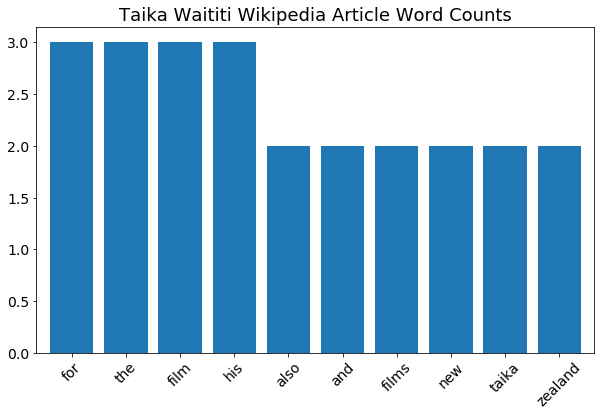

In [7]:
name = 'Taika Waititi'
#Extract text for a particular person
text = wiki_data[name]
#Define the count vectorizer that will be used to process the data
count_vectorizer = CountVectorizer()
#Apply this vectorizer to text to get a sparse matrix of counts
count_matrix = count_vectorizer.fit_transform([text])
#Get the names of the features
features = count_vectorizer.get_feature_names()
#Create a series from the sparse matrix
d = pd.Series(count_matrix.toarray().flatten(), 
              index = features).sort_values(ascending=False)

ax = d[:10].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=45,
            title='Taika Waititi Wikipedia Article Word Counts')
ax.title.set_size(18)


## Compute TF-IDF

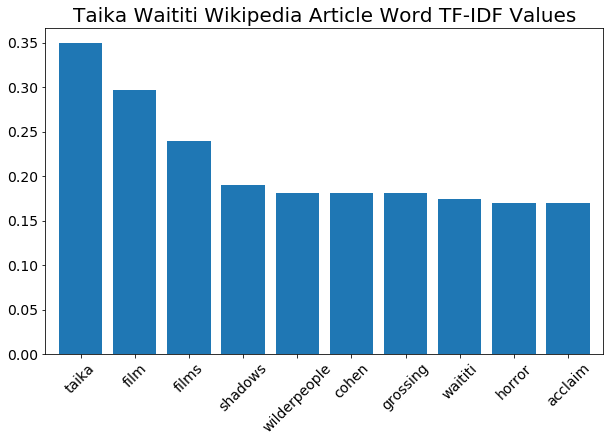

In [8]:
#Define the TFIDF vectorizer that will be used to process the data
tfidf_vectorizer = TfidfVectorizer()
#Apply this vectorizer to the full dataset to create normalized vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(wiki_data)
#Get the names of the features
features = tfidf_vectorizer.get_feature_names()
#get the row that contains relevant vector
row = wiki_data.index.get_loc(name)
#Create a series from the sparse matrix
d = pd.Series(tfidf_matrix.getrow(row).toarray().flatten(), index = features).sort_values(ascending=False)

ax = d[:10].plot(kind='bar', title='Taika Waititi Wikipedia Article Word TF-IDF Values',
            figsize=(10,6), width=.8, fontsize=14, rot=45 )
ax.title.set_size(20)

## Search the kNN

In [9]:
nbrs = NearestNeighbors(n_neighbors=10, metric='cosine').fit(tfidf_matrix)
distances, indices = nbrs.kneighbors()

def get_closest_neighs(name):
    row = wiki_data.index.get_loc(name)
    result = pd.DataFrame({'names':wiki_data.iloc[indices[row],].reset_index()['name'],
                           'distance': distances[row].flatten()})
    return result

In [12]:
get_closest_neighs('Taika Waititi')

,names,distance
0,Julian Dennison,0.660181
1,James Napier Robertson,0.732818
2,Elsie Jane Wilson,0.768437
3,Shayne Biddle,0.770290
4,David Hannay,0.780479
5,Russell Crowe,0.786320
6,Jamie Selkirk,0.787253
7,Stephen Kay,0.793299
8,Roger Oakley,0.800582
9,Barbara Sumner-Burstyn,0.814267


In [13]:
nbrs = NearestNeighbors(n_neighbors=10, metric='euclidean').fit(tfidf_matrix)
distances, indices = nbrs.kneighbors()

def get_closest_neighs(name):
    row = wiki_data.index.get_loc(name)
    result = pd.DataFrame({'names':wiki_data.iloc[indices[row],].reset_index()['name'],
                           'distance': distances[row].flatten()})
    return result

In [14]:
# Find the closest neighbors for Alan Bolton
get_closest_neighs('Alan Bolton')

,names,distance
0,Mike Day,1.130892
1,Tina Osborne,1.165842
2,Craig Caldwell,1.211612
3,Peter Hunt,1.237124
4,Preston Ridd,1.248290
5,Cody Harris,1.255030
6,Phillip Hazel,1.261450
7,Bernie Smith,1.263866
8,Rob Szabo,1.269636
9,Elias Scheres,1.275467


# Metagenomes as text documents

In [17]:
# import the Bray-curtis distance matrix and metagenome description

bc_25bp=pd.read_csv('SIMKA_results/bc_25.csv', header=None)

samples=pd.read_csv('SIMKA_results/metagenomes_description.csv', index_col='ID')['body_site']

samples

ID
sample_1     stool
sample_2     stool
sample_3    tongue
sample_4    tongue
sample_5    dental
sample_6     stool
Name: body_site, dtype: object

In [18]:
# create a 2-NN search for the samples
nbrs = NearestNeighbors(n_neighbors=2, metric='precomputed').fit(bc_25bp)
distances, indices = nbrs.kneighbors()

def get_closest_neighs(ID):
    row = samples.index.get_loc(ID)
    result = pd.DataFrame({'ID':samples.iloc[indices[row],].reset_index()['ID'], 'distance':distances[row].flatten(),
                          'body_site': samples.iloc[indices[row],].reset_index()['body_site']})
    return result

In [19]:
# Retrieve the two NN for 'sample_6'
get_closest_neighs('sample_6')

,ID,distance,body_site
0,sample_2,0.821734,stool
1,sample_1,0.876150,stool
